In [43]:
import pandas as pd;import math;import numpy as np; import geopandas as gpd; import matplotlib as plt; import gc; import sklearn; import re; import prophet

Load data

In [44]:
df1 = pd.read_csv("Data/siss_geo_indicatori_lineari_2016.csv", sep=",", encoding='utf-8')
df2 = pd.read_csv("Data/siss_geo_indicatori_lineari_2017.csv", sep=",", encoding='utf-8')
df3 = pd.read_csv("Data/siss_geo_indicatori_lineari_2018.csv", sep=",", encoding='utf-8')
df4 = pd.read_csv("Data/siss_geo_indicatori_lineari_2019.csv", sep=",", encoding='utf-8')
df5 = pd.read_csv("Data/siss_geo_indicatori_lineari_2020.csv", sep=",", encoding='utf-8')
df6 = pd.read_csv("Data/siss_geo_indicatori_lineari_2021.csv", sep=",", encoding='utf-8')
df7 = pd.read_csv("Data/siss_geo_indicatori_lineari_2022.csv", sep=",", encoding='utf-8')
df1['Year'] = 2016
df2['Year'] = 2017
df3['Year'] = 2018
df4['Year'] = 2019
df5['Year'] = 2020
df6['Year'] = 2021
df7['Year'] = 2022
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], sort=False)

C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\2450062250.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("Data/siss_geo_indicatori_lineari_2016.csv", sep=",", encoding='utf-8')
C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\2450062250.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("Data/siss_geo_indicatori_lineari_2017.csv", sep=",", encoding='utf-8')
C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\2450062250.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv("Data/siss_geo_indicatori_lineari_2018.csv", sep=",", encoding='utf-8')
C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\2450062250.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv("Data/siss_geo_indicatori_li

In [45]:
del df1, df2, df3, df4, df5, df6, df7
gc.collect()

527231

Create unique geolocation

In [46]:
df['geometria'] = gpd.GeoSeries.from_wkt(df['geometria'])

In [47]:
pd.set_option('display.max_columns', 100)  # or however many you need
pd.set_option('display.float_format', '{:.4f}'.format)
gdf1 = gpd.GeoDataFrame(df, geometry='geometria')
gdf1['length'] = gdf1.geometry.length
gdf1['centroid'] = gdf1.geometry.centroid
# fix uuids
gdf1['uid'] = gdf1['uuid'].str.upper()
gdf1['uid'] = gdf1['uid'].astype(str)                         # convert all to string
gdf1['uid'] = gdf1['uid'].str.strip()                         # remove leading/trailing whitespace
gdf1['uid'] = gdf1['uid'].str.replace(r'\s+', ' ', regex=True)  # normalise spaces
gdf1['uid'] = gdf1['uid'].str.replace(r'[^\x00-\x7F]+', '', regex=True)  # remove non-ASCII
# find longest geometry for each uuid
helper = gdf1.sort_values(by=['uid','length'], ascending=[True, False])
helper['maxgeometry'] = np.where(helper['uid'] == helper['uid'].shift()  , helper['geometria'].shift(), helper['geometria'])#
helper['maxlength'] = np.where(helper['uid'] == helper['uid'].shift()  , helper['length'].shift(), helper['length'])  
helper_0 = helper.groupby('uid', as_index=False).first()
gdf1['maxgeometry'] = gdf1['uid'].map(helper_0.set_index('uid')['maxgeometry']).fillna(0)
gdf1['maxlength'] = gdf1['uid'].map(helper_0.set_index('uid')['maxlength']).fillna(0)
# find accident for each uuid and find also max length for each uuid
accidents = gdf1[gdf1['nr_incidenti'] > 0]
helper = accidents.sort_values(by=['uid','length'], ascending=[True, False])
helper['maxgeometry_accidents'] = np.where(helper['uid'] == helper['uid'].shift()  , helper['geometria'].shift(), helper['geometria'])#
helper['maxlength_accidents'] = np.where(helper['uid'] == helper['uid'].shift()  , helper['length'].shift(), helper['length'])  
helper_0 = helper.groupby('uid', as_index=False).first()
gdf1['maxgeometry_accidents'] = gdf1['uid'].map(helper_0.set_index('uid')['maxgeometry_accidents']).fillna(0)
gdf1['maxlength_accidents'] = gdf1['uid'].map(helper_0.set_index('uid')['maxlength_accidents']).fillna(0)
# if accidents in multiple years, keep the one with the longest length
helper = accidents.groupby('uid', as_index=False, sort=False).agg({'geometria':'nunique','Year':'nunique','nr_incidenti':'sum'})
gdf1['accident_in_uuid'] = gdf1.uid.isin(helper.uid).astype(int)
acc_in_many_years_2 = helper[(helper['Year'] > 1) & (helper['geometria'] > 1)]
gdf1['acc_in_many_years'] = gdf1.uid.isin(acc_in_many_years_2.uid).astype(int)
gdf1['u_geometria'] = np.where(gdf1['accident_in_uuid'] == 1 , gdf1['maxgeometry_accidents'], gdf1['maxgeometry'])
gdf1['u_length'] = np.where(gdf1['accident_in_uuid'] == 1 , gdf1['maxlength_accidents'], gdf1['maxlength'])
# gdf1.head()

In [48]:
del helper, helper_0, accidents, acc_in_many_years_2 #, gdf1, distances, possible_matches, possible_matches_index, buffer, bounds, idx, row, neighbour_indices, total_accidents 
gc.collect()

0

Null Info:

In [49]:
nullinall = gdf1['t_incidentalita_flusso_tr'].isnull().mean()
accidents = gdf1[gdf1['nr_incidenti'] > 0]
nullinacc = accidents['t_incidentalita_flusso_tr'].isnull().mean()
print(nullinall,nullinacc)

0.13773987182571298 0.05845384752722728


In [50]:
print(accidents['t_incidentalita_flusso_tr'].mean(),accidents['t_incidentalita_flusso_tr'].max(),accidents['t_incidentalita_flusso_tr'].std())


15.43946731248439 44836.36408472728 282.07081684664394


Transformation

In [51]:
tranformed_df = gdf1.drop(columns=['maxgeometry', 'maxlength','maxgeometry_accidents','maxlength_accidents','acc_in_many_years'])

# Get column names at specific positions, e.g., index 1 and 2
cols_to_drop = tranformed_df.columns[[8,14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]]

# Drop those columns
tranformed_df = tranformed_df.drop(columns=cols_to_drop)

Test existence of a uid in subsequent years

In [52]:
# Ensure year column is integer
tranformed_df['Year'] = tranformed_df['Year'].astype(int)

# Define expected full year range
expected_years = set(range(2016, 2023))  # inclusive of 2022

# Initialise dictionaries to hold computed values
years_present_dict = {}
years_missing_dict = {}
has_all_subsequent_years_dict = {}
first_year_dict = {}
has_full_range_dict = {}

# Group by uid and compute values
for uid, group in tranformed_df.groupby('uid'):
    present_years = sorted(group['Year'].unique())
    missing_years = sorted(expected_years - set(present_years))

    # First year
    first_year = present_years[0] if present_years else None

    # Check if all subsequent years exist
    has_all_subsequent = all((present_years[i+1] - present_years[i]) == 1 
                             for i in range(len(present_years) - 1)) if len(present_years) > 1 else False

    # Check if all years from 2016 to 2022 are present
    has_full_range = set(present_years) == expected_years

    # Save results
    years_present_dict[uid] = present_years
    years_missing_dict[uid] = missing_years
    has_all_subsequent_years_dict[uid] = has_all_subsequent
    first_year_dict[uid] = first_year
    has_full_range_dict[uid] = has_full_range

# Map results back to dataframe
tranformed_df['years_present'] = tranformed_df['uid'].map(years_present_dict)
tranformed_df['years_missing'] = tranformed_df['uid'].map(years_missing_dict)
tranformed_df['has_all_subsequent_years'] = tranformed_df['uid'].map(has_all_subsequent_years_dict)
tranformed_df['first_year'] = tranformed_df['uid'].map(first_year_dict)
tranformed_df['has_full_range'] = tranformed_df['uid'].map(has_full_range_dict)

Find neighbours only for uids having at least an accident 

In [53]:
import geopandas as gpd
from shapely.geometry import Point

acc = tranformed_df[tranformed_df['has_all_subsequent_years'] == True] 
acc = acc[acc['accident_in_uuid'] == 1]

# Ensure GeoDataFrame with geometry
acc = gpd.GeoDataFrame(acc, geometry='u_geometria')
acc.set_crs(epsg=32632, inplace=True)

# Buffer each segment
buffered = acc.copy()
buffered['u_geometria'] = buffered['u_geometria'].buffer(20)
# Ensure CRS match
buffered = buffered.set_crs(acc.crs)

# Spatial join to find neighbours *within the same year*
joined = gpd.sjoin(
    buffered[['u_geometria', 'Year']],  # buffered geometries with year
    acc[['u_geometria', 'Year', 'nr_incidenti', 'nr_incidenti_feriti',
         'nr_incidenti_morti', 'nr_feriti', 'nr_morti']],
    how='left',
    predicate='intersects'
).rename(columns={'index_right': 'neigh_idx'}).reset_index()

# Rename for clarity
joined.rename(columns={'index': 'row_idx'}, inplace=True)

# Keep only matches within the same year
joined = joined[joined['Year_left'] == joined['Year_right']]

# Group by the original segment (index), summing neighbour stats
agg = (
    joined.groupby('row_idx')
    .agg({
        'nr_incidenti': 'sum',
        'nr_incidenti_feriti': 'sum',
        'nr_incidenti_morti': 'sum',
        'nr_feriti': 'sum',
        'nr_morti': 'sum',
        'neigh_idx': 'count'  # number of neighbours including self
    })
    .rename(columns={
        'nr_incidenti': 'accidents_with_neighbours',
        'nr_incidenti_feriti': 'accidents_inj_with_neighbours',
        'nr_incidenti_morti': 'accidents_d_with_neighbours',
        'nr_feriti': 'n_inj_with_neighbours_list',
        'nr_morti': 'n_d_with_neighbours_list',
        'neigh_idx': 'n_neighbours'
    })
)

# Join neighbour stats to main dataset
acc = acc.join(agg, how='left')

# Fill NaNs where no neighbours exist
acc.fillna({
    'accidents_neigh': 0,
    'accidents_inj_neigh': 0,
    'accidents_d_neigh': 0,
    'n_inj_neigh': 0,
    'n_d_neigh': 0,
    'n_neighbours':0
}, inplace=True)


In [54]:
top_scores = acc.nlargest(10, 'accidents_with_neighbours')
top_scores.head()

,uuid,fk_l3,es_amm_nom,fk_l2,tp_str_nom,cod_comune,desc_comune,flusso_medio_gior,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,group_strada,flusso_medio_gior_s,geometria,Year,length,centroid,uid,accident_in_uuid,u_geometria,u_length,years_present,years_missing,has_all_subsequent_years,first_year,has_full_range,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list,n_neighbours
426188,C150E172-4917-452B-E044-0003BA0F36E6,0.0000,NaN,39766.0000,VIA GRADO,103072.0000,VERBANIA,NaN,0,0,0,0,0,fkl2_39766,0,"LINESTRING (464331.25 5086866.5, 464327.062 50...",2018,87.9725,POINT (464351.277 5086892.005),C150E172-4917-452B-E044-0003BA0F36E6,1,"LINESTRING (464331.25 5086866.5, 464327.062 50...",87.9727,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,51,51,0,59,0,8
426188,2ad98102-3f94-4738-e054-0003ba0f36e6,60036.0000,SP 565 di Castellamonte,0.0000,NaN,999999.0000,NaN,0.0000,0,0,0,0,0,fkl3_60036,975020,"LINESTRING (401943.632 5027397.764, 401949.62 ...",2019,16.2274,POINT (401948.386 5027403.936),2AD98102-3F94-4738-E054-0003BA0F36E6,1,"LINESTRING (401943.632 5027397.764, 401949.62 ...",16.2272,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,51,51,0,59,0,8
426188,093cb267-926f-2909-e054-0003ba0f36e6,NaN,NaN,17636.0000,CORSO SEBASTOPOLI,NaN,TORINO,4036.0000,0,0,0,0,0,fkl2_17636,392860,"LINESTRING (393281.25 4988890.5, 393260.625 49...",2021,22.9214,POINT (393270.938 4988895.5),093CB267-926F-2909-E054-0003BA0F36E6,1,"LINESTRING (393281.25 4988890.5, 393260.625 49...",22.9213,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,51,51,0,59,0,8
172741,C150E172-48C7-452B-E044-0003BA0F36E6,0.0000,NaN,39766.0000,VIA GRADO,103072.0000,VERBANIA,NaN,0,0,0,0,0,fkl2_39766,0,"LINESTRING (464387.938 5086906.5, 464395.344 5...",2018,132.3535,POINT (464447.792 5086901.245),C150E172-48C7-452B-E044-0003BA0F36E6,1,"LINESTRING (464387.938 5086906.5, 464395.344 5...",132.3530,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,48,48,0,55,0,3
201770,093CB25E-F349-2909-E054-0003BA0F36E6,0.0000,NaN,39766.0000,VIA GRADO,103072.0000,VERBANIA,NaN,48,48,0,55,0,fkl2_39766,0,"LINESTRING (464215.344 5087141.5, 464226.938 5...",2018,825.0843,POINT (464317.198 5087035.19),093CB25E-F349-2909-E054-0003BA0F36E6,1,"LINESTRING (464215.344 5087141.5, 464226.938 5...",825.0843,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,48,48,0,55,0,3


Trend

In [55]:
from numpy.polynomial.polynomial import polyfit

alla = acc.copy()
# Function to compute linear trend with minimum 3 points
def compute_trend(group):
    years = group['Year'].values
    acc = group['accidents_with_neighbours'].values

    if len(acc) < 3:
        return pd.Series({'trend': np.nan})

    x = years - years.mean()
    coeffs = polyfit(x, acc, deg=1)
    trend = coeffs[1]

    return pd.Series({'trend': trend})

# Apply per UID (no full reindexing!)
trend_df = alla.groupby('uid', group_keys=False).apply(compute_trend).reset_index()
trend_df.head()

C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\4054986524.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_df = alla.groupby('uid', group_keys=False).apply(compute_trend).reset_index()


,uid,trend
0,0038B05A-8CB6-445D-8356-B49BE52E34BD,0.6000
1,004BDE73-73D8-4232-9000-B447D5897261,1.5000
2,00F783E8-3F44-6997-E054-0003BA0F36E6,0.0357
3,00FFF2A8-50B2-4308-9926-7F2A11761EA4,1.5000
4,010CACED-9F1B-55D3-E054-0003BA0F36E6,-0.1429


Trend Cluster

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd

# Step 1: Select and scale the 'trend' feature
features = ['trend']
X = trend_df[features].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)

# Step 2: Fit GMM
gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_scaled)
initial_labels = gmm.predict(X_scaled)
trend_df['initial_trend_GMM'] = initial_labels

# Step 3: Calculate mean trend per cluster
cluster_means = trend_df.groupby('initial_trend_GMM')['trend'].mean()

# Step 4: Sort clusters by average trend and create a mapping
sorted_clusters = cluster_means.sort_values().index.tolist()
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}

# Step 5: Remap to ordered labels
trend_df['trend_GMM'] = trend_df['initial_trend_GMM'].map(cluster_mapping)

# Optional: Drop the temporary label
trend_df.drop(columns='initial_trend_GMM', inplace=True)


In [57]:
uidgroups = acc.groupby(['uid'], as_index=False,sort=True).agg({'nr_incidenti':'sum','nr_incidenti_feriti':'sum','nr_incidenti_morti':'sum','nr_feriti':'sum','nr_morti':'sum','u_geometria':"first", 'fk_l3':"first",'fk_l2':"first",'cod_comune':"first",'desc_comune':"first",'group_strada':"first", 'flusso_medio_gior':"first",'accidents_with_neighbours':'sum','accidents_inj_with_neighbours':'sum','accidents_d_with_neighbours':'sum','n_inj_with_neighbours_list':'sum','n_d_with_neighbours_list':'sum'})
uidgroups = gpd.GeoDataFrame(uidgroups, geometry='u_geometria')
uidgroups['u_lengthx'] = uidgroups.geometry.length

In [58]:
data = uidgroups.merge(trend_df[['uid', 'trend','trend_GMM']],on='uid',how='left')
print(data.shape, trend_df.shape, uidgroups.shape)
# data.head()

(37675, 21) (37675, 3) (37675, 19)


In [59]:
acc[acc['uid'] == uid].head(10)

,uuid,fk_l3,es_amm_nom,fk_l2,tp_str_nom,cod_comune,desc_comune,flusso_medio_gior,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,group_strada,flusso_medio_gior_s,geometria,Year,length,centroid,uid,accident_in_uuid,u_geometria,u_length,years_present,years_missing,has_all_subsequent_years,first_year,has_full_range,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list,n_neighbours


Risk cluster

In [60]:

# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd

# Features related to accident severity
features = [
    'accidents_with_neighbours',
    'accidents_inj_with_neighbours',
    'accidents_d_with_neighbours',
    'n_inj_with_neighbours_list',
    'n_d_with_neighbours_list'
]

# Prepare and scale data
X = data[features].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)

# Fit GMM
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(X_scaled)
initial_labels = gmm.predict(X_scaled)

# Temporarily assign labels
data['initial_risk_GMM'] = initial_labels

# Compute average accident count per cluster (or a weighted score)
cluster_means = data.groupby('initial_risk_GMM')[features].mean()
cluster_scores = cluster_means.sum(axis=1)  # or use a weighted sum if you prefer

# Sort clusters by risk score and create a mapping
sorted_clusters = cluster_scores.sort_values().index.tolist()
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}

# Re-map cluster labels so higher number = higher accident likelihood
data['risk_GMM'] = data['initial_risk_GMM'].map(cluster_mapping)

# Optional: drop the initial label
# data.drop(columns='initial_risk_GMM', inplace=True)


In [61]:
probabilities = gmm.predict_proba(X_scaled)
data['risk_GMM_0'] = probabilities[:, 0] 
data['risk_GMM_1'] = probabilities[:, 1]#cluster_1_probs
data['risk_GMM_2'] = probabilities[:, 2]#cluster_2_probs
data['risk_GMM_3'] = probabilities[:, 3]#cluster_3_probs
data['risk_GMM_4'] = probabilities[:, 4]#cluster_4_probs
data['risk_GMM_5'] = probabilities[:, 5]#cluster_5_probs

In [62]:
data[data['uid'] == uid].head(10)

,uid,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,u_geometria,fk_l3,fk_l2,cod_comune,desc_comune,group_strada,flusso_medio_gior,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list,u_lengthx,trend,trend_GMM,initial_risk_GMM,risk_GMM,risk_GMM_0,risk_GMM_1,risk_GMM_2,risk_GMM_3,risk_GMM_4,risk_GMM_5


Merge

In [63]:
acc_trend = acc.merge(data[['uid', 'trend','risk_GMM', 'initial_risk_GMM','trend_GMM','risk_GMM_0','risk_GMM_1','risk_GMM_2','risk_GMM_3','risk_GMM_4','risk_GMM_5']], on='uid', how='left')
print(acc_trend.shape, data.shape, acc.shape)

data_all = tranformed_df.merge(acc_trend[['uid','Year', 'trend','trend_GMM', 'risk_GMM', 'initial_risk_GMM','risk_GMM_0','risk_GMM_1','risk_GMM_2','risk_GMM_3','risk_GMM_4','risk_GMM_5','accidents_with_neighbours','accidents_inj_with_neighbours','accidents_d_with_neighbours','n_inj_with_neighbours_list','n_d_with_neighbours_list']],on=['uid','Year'],how='left')
print(data_all.shape, acc_trend.shape, tranformed_df.shape)
data_all[data_all['uid'] == uid].head(10)


(258312, 44) (37675, 29) (258312, 34)
(3516774, 43) (258312, 44) (3516774, 28)


,uuid,fk_l3,es_amm_nom,fk_l2,tp_str_nom,cod_comune,desc_comune,flusso_medio_gior,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,group_strada,flusso_medio_gior_s,geometria,Year,length,centroid,uid,accident_in_uuid,u_geometria,u_length,years_present,years_missing,has_all_subsequent_years,first_year,has_full_range,trend,trend_GMM,risk_GMM,initial_risk_GMM,risk_GMM_0,risk_GMM_1,risk_GMM_2,risk_GMM_3,risk_GMM_4,risk_GMM_5,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list
1521528,fffcd2e5-b0ef-43c2-b961-b03a9381a6fe,0.0000,NaN,53298.0000,Via Augusto Monti,5017.0000,CANELLI,0.0000,0,0,0,0,0,fkl2_53298,0,"LINESTRING (444469.938 4952731, 444465.031 495...",2019,28.4267,POINT (444467.484 4952717),FFFCD2E5-B0EF-43C2-B961-B03A9381A6FE,0,"LINESTRING (444469.938 4952731, 444465.031 495...",28.4267,"[2019, 2020, 2021, 2022]","[2016, 2017, 2018]",True,2019,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2425814,fffcd2e5-b0ef-43c2-b961-b03a9381a6fe,NaN,NaN,53298.0000,VIA MONTI AUGUSTO,NaN,CANELLI,NaN,0,0,0,0,0,fkl2_53298,0,"LINESTRING (444469.938 4952731, 444465.031 495...",2020,28.4267,POINT (444467.484 4952717),FFFCD2E5-B0EF-43C2-B961-B03A9381A6FE,0,"LINESTRING (444469.938 4952731, 444465.031 495...",28.4267,"[2019, 2020, 2021, 2022]","[2016, 2017, 2018]",True,2019,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2669469,fffcd2e5-b0ef-43c2-b961-b03a9381a6fe,NaN,NaN,53298.0000,VIA MONTI AUGUSTO,NaN,CANELLI,NaN,0,0,0,0,0,fkl2_53298,0,"LINESTRING (444469.938 4952731, 444465.031 495...",2021,28.4267,POINT (444467.484 4952717),FFFCD2E5-B0EF-43C2-B961-B03A9381A6FE,0,"LINESTRING (444469.938 4952731, 444465.031 495...",28.4267,"[2019, 2020, 2021, 2022]","[2016, 2017, 2018]",True,2019,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3173154,fffcd2e5-b0ef-43c2-b961-b03a9381a6fe,NaN,NaN,53298.0000,VIA MONTI AUGUSTO,5017.0000,CANELLI,NaN,0,0,0,0,0,fkl2_53298,0,"LINESTRING (444469.938 4952731, 444465.031 495...",2022,28.4267,POINT (444467.484 4952717),FFFCD2E5-B0EF-43C2-B961-B03A9381A6FE,0,"LINESTRING (444469.938 4952731, 444465.031 495...",28.4267,"[2019, 2020, 2021, 2022]","[2016, 2017, 2018]",True,2019,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# data is only accidents

# data_all = tranformed_df.merge(data[['uid', 'trend','trend_GMM', 'risk_GMM','risk_GMM_0','risk_GMM_1','risk_GMM_2','risk_GMM_3','risk_GMM_4','risk_GMM_5','accidents_with_neighbours','accidents_inj_with_neighbours','accidents_d_with_neighbours','n_inj_with_neighbours_list','n_d_with_neighbours_list']],on='uid',how='left')
data_all['trend'] = data_all['trend'].fillna(0)
data_all['trend_GMM'] = data_all['trend_GMM'].fillna(0)
data_all['risk_GMM'] = data_all['risk_GMM'].fillna(0)
data_all['initial_risk_GMM'] = data_all['initial_risk_GMM'].fillna(0)
data_all['risk_GMM_0'] = data_all['risk_GMM_0'].fillna(0)
data_all['risk_GMM_1'] = data_all['risk_GMM_1'].fillna(0)
data_all['risk_GMM_2'] = data_all['risk_GMM_2'].fillna(0)       
data_all['risk_GMM_3'] = data_all['risk_GMM_3'].fillna(0)   
data_all['risk_GMM_4'] = data_all['risk_GMM_4'].fillna(0)
data_all['risk_GMM_5'] = data_all['risk_GMM_5'].fillna(0)
data_all['accidents_with_neighbours'] = data_all['accidents_with_neighbours'].fillna(0)
data_all['accidents_inj_with_neighbours'] = data_all['accidents_inj_with_neighbours'].fillna(0)
data_all['accidents_d_with_neighbours'] = data_all['accidents_d_with_neighbours'].fillna(0)
data_all['n_inj_with_neighbours_list'] = data_all['n_inj_with_neighbours_list'].fillna(0)
data_all['n_d_with_neighbours_list'] = data_all['n_d_with_neighbours_list'].fillna(0)
# data_all_sorted = data_all.sort_values(by='risk_GMM_6', ascending=False)
print(data_all.shape, data.shape)

(3516774, 43) (37675, 29)


Static Risk Cluster

In [65]:
import pandas as pd
import numpy as np

def add_composite_risk(df):
    """
    Adds a 'composite_risk' column to the DataFrame based on:
    - The discrete cluster assignment in 'risk_GMM' (0 to 5)
    - The corresponding continuous value from 'risk_GMM_0' to 'risk_GMM_5'
    - Mapping of clusters to new continuous ranges:
        0 → [0, 2]
        1 → [2.1, 4]
        2 → [4.1, 6]
        3 → [6.1, 8]
        4 → [8.1, 10]
        5 → [10.1, 12]
    """
    # Define the mapping ranges
    risk_ranges = {
        0: (0, 2),
        1: (2.1, 4),
        2: (4.1, 6),
        3: (6.1, 8),
        4: (8.1, 10),
        5: (10.1, 12)
    }

    def compute_composite(row):
        cluster_initial = int(row['initial_risk_GMM'])
        cluster = int(row['risk_GMM'])
        prob_value = row[f'risk_GMM_{cluster_initial}']
        min_r, max_r = risk_ranges[cluster]
        # Scale prob_value ∈ [0,1] into [min_r, max_r]
        return min_r + prob_value * (max_r - min_r)

    # Apply the function row-wise
    df['static_risk_cluster'] = df.apply(compute_composite, axis=1)
    return df

data_all = add_composite_risk(data_all)
data_all['static_risk_cluster'] = data_all['static_risk_cluster'].fillna(0)
# data_all.head(250)

Grouping by Road Segment and Scaling of Metrics of Interest

In [66]:
# accuidgroups = acc.groupby(['uid'], as_index=False,sort=True).agg({'trend':'first','trend_GMM':'first','risk_GMM':'first','risk_GMM_4':'first','nr_incidenti':'sum','nr_incidenti_feriti':'sum','nr_incidenti_morti':'sum','nr_feriti':'sum','nr_morti':'sum','u_geometria':"first", 'fk_l3':"first",'fk_l2':"first",'cod_comune':"first",'group_strada':"first", 'flusso_medio_gior':"first",'accidents_with_neighbours':'sum','accidents_inj_with_neighbours':'sum','accidents_d_with_neighbours':'sum','n_inj_with_neighbours_list':'sum','n_d_with_neighbours_list':'sum'})
uidgroups = data_all.groupby(['uid'], as_index=False,sort=True).agg({'trend':'first','trend_GMM':'first','risk_GMM':'first','initial_risk_GMM':'first','static_risk_cluster':'first','risk_GMM_0':'first','risk_GMM_1':'first','risk_GMM_2':'first','risk_GMM_3':'first','risk_GMM_4':'first','risk_GMM_5':'first','desc_comune':'first','nr_incidenti':'sum','nr_incidenti_feriti':'sum','nr_incidenti_morti':'sum','nr_feriti':'sum','nr_morti':'sum','u_geometria':"first", 'fk_l3':"first",'fk_l2':"first",'cod_comune':"first",'group_strada':"first", 'flusso_medio_gior':"first",'accident_in_uuid':'first','accidents_with_neighbours':'sum','accidents_inj_with_neighbours':'sum','accidents_d_with_neighbours':'sum','n_inj_with_neighbours_list':'sum','n_d_with_neighbours_list':'sum'}) 
uidgroups = gpd.GeoDataFrame(uidgroups, geometry='u_geometria')

In [67]:
# Scale the values
from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['static_risk_cluster', 'trend']

scaler = MinMaxScaler() #StandardScaler
scaled_values = scaler.fit_transform(uidgroups[cols_to_scale])

# Add the scaled columns back to the DataFrame (optional)
uidgroups[['static_risk_cluster_scaled', 'trend_scaled']] = scaled_values

# Add their values row-wise into a new column
uidgroups['combined_score'] = 0.5*uidgroups['static_risk_cluster_scaled'] + 0.5*uidgroups['trend_scaled']

In [68]:
uid = '093CB26A-8097-2909-E054-0003BA0F36E6'
uid = uid.upper()  # Ensure the UID is in uppercase
uidgroups[uidgroups['uid'] == uid].head(10)

,uid,trend,trend_GMM,risk_GMM,initial_risk_GMM,static_risk_cluster,risk_GMM_0,risk_GMM_1,risk_GMM_2,risk_GMM_3,risk_GMM_4,risk_GMM_5,desc_comune,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,u_geometria,fk_l3,fk_l2,cod_comune,group_strada,flusso_medio_gior,accident_in_uuid,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list,static_risk_cluster_scaled,trend_scaled,combined_score
363052,093CB26A-8097-2909-E054-0003BA0F36E6,3.5357,8.0000,5.0000,2.0000,12.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,TORINO,4,4,0,5,0,"LINESTRING (394242.656 4993358, 394231.031 499...",0.0000,17625.0000,1272.0000,fkl2_17625,5165.0000,1,79.0000,77.0000,2.0000,107.0000,2.0000,1.0000,0.5970,0.7985


In [87]:
uidgroups.head()
group_accidents = uidgroups[uidgroups['nr_incidenti'] > 0]
group_accidents.to_csv("trend_risk_accidents.csv", index=False)
group_accidents.head()

,uid,trend,trend_GMM,risk_GMM,static_risk_cluster,trend_scaled,combined_score,static_risk_cluster_scaled,initial_risk_GMM,risk_GMM_0,risk_GMM_1,risk_GMM_2,risk_GMM_3,risk_GMM_4,risk_GMM_5,desc_comune,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,u_geometria,fk_l3,fk_l2,cod_comune,group_strada,flusso_medio_gior,accident_in_uuid,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list,is_high_risk,is_high_trend
16,0038B05A-8CB6-445D-8356-B49BE52E34BD,0.6000,7.0000,0.0000,1.7662,0.3986,0.2729,0.1472,0.0000,0.8831,0.0000,0.0000,0.0028,0.0000,0.1141,RIVOLI,1,1,0,1,0,"LINESTRING (384927.679 4989920.366, 385229.531...",0.0000,14225.0000,1219.0000,fkl2_14225,0.0000,1,4.0000,4.0000,0.0000,6.0000,0.0000,0,0
27,004BDE73-73D8-4232-9000-B447D5897261,1.5000,9.0000,0.0000,1.9206,0.4595,0.3098,0.1601,0.0000,0.9603,0.0000,0.0000,0.0014,0.0000,0.0383,LA LOGGIA,1,1,0,2,0,"LINESTRING (394931.518 4979441.451, 394940.246...",NaN,8557.0000,1127.0000,fkl2_8557,4552.0000,1,3.0000,3.0000,0.0000,4.0000,0.0000,0,1
176,00F783E8-3F44-6997-E054-0003BA0F36E6,0.0357,5.0000,0.0000,1.9251,0.3605,0.2605,0.1604,0.0000,0.9625,0.0000,0.0000,0.0027,0.0000,0.0348,MONTEMARZINO,1,1,0,1,0,"LINESTRING (498283 4964312, 498295.219 4964324...",70021.0000,61534.0000,6108.0000,fkl3_70021,280.0000,1,1.0000,1.0000,0.0000,1.0000,0.0000,0,0
180,00FFF2A8-50B2-4308-9926-7F2A11761EA4,1.5000,9.0000,0.0000,1.2522,0.4595,0.2819,0.1044,0.0000,0.6261,0.0000,0.0000,0.0151,0.0000,0.3588,RIVOLI,2,2,0,2,0,"LINESTRING (383491.769 4991863.98, 383493.385 ...",0.0000,14171.0000,1219.0000,fkl2_14171,0.0000,1,7.0000,7.0000,0.0000,7.0000,0.0000,0,1
191,010CACED-9F1B-55D3-E054-0003BA0F36E6,-0.1429,4.0000,0.0000,1.7469,0.3485,0.2470,0.1456,0.0000,0.8735,0.0000,0.0000,0.0036,0.0000,0.1229,ALESSANDRIA,1,1,0,2,0,"LINESTRING (466135.906 4976155.5, 466101.844 4...",50003.0000,200704.0000,6003.0000,fkl3_50003,14243.0000,1,3.0000,3.0000,0.0000,5.0000,0.0000,0,0


In [69]:
data_all[data_all['uid'] == uid].head(10)

,uuid,fk_l3,es_amm_nom,fk_l2,tp_str_nom,cod_comune,desc_comune,flusso_medio_gior,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,group_strada,flusso_medio_gior_s,geometria,Year,length,centroid,uid,accident_in_uuid,u_geometria,u_length,years_present,years_missing,has_all_subsequent_years,first_year,has_full_range,trend,trend_GMM,risk_GMM,initial_risk_GMM,risk_GMM_0,risk_GMM_1,risk_GMM_2,risk_GMM_3,risk_GMM_4,risk_GMM_5,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list,static_risk_cluster
321759,093CB26A-8097-2909-E054-0003BA0F36E6,0.0000,NaN,17625.0000,CORSO REGINA MARGHERITA,1272.0000,TORINO,5165.0000,2,2,0,2,0,fkl2_17625,3097176,"LINESTRING (394242.656 4993358, 394231.031 499...",2016,12.8604,POINT (394236.844 4993360.75),093CB26A-8097-2909-E054-0003BA0F36E6,1,"LINESTRING (394242.656 4993358, 394231.031 499...",12.8604,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,3.5357,8.0000,5.0000,2.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,4.0000,4.0000,0.0000,5.0000,0.0000,12.0000
529697,093CB26A-8097-2909-E054-0003BA0F36E6,0.0000,NaN,17625.0000,CORSO REGINA MARGHERITA,1272.0000,TORINO,4967.0000,0,0,0,0,0,fkl2_17625,2807728,"LINESTRING (394242.656 4993358, 394231.031 499...",2017,12.8604,POINT (394236.844 4993360.75),093CB26A-8097-2909-E054-0003BA0F36E6,1,"LINESTRING (394242.656 4993358, 394231.031 499...",12.8604,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,3.5357,8.0000,5.0000,2.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,3.0000,3.0000,0.0000,4.0000,0.0000,12.0000
1075109,093CB26A-8097-2909-E054-0003BA0F36E6,0.0000,NaN,17625.0000,CORSO REGINA MARGHERITA,1272.0000,TORINO,4659.0000,0,0,0,0,0,fkl2_17625,2798584,"LINESTRING (394242.656 4993358, 394231.031 499...",2018,12.8604,POINT (394236.844 4993360.75),093CB26A-8097-2909-E054-0003BA0F36E6,1,"LINESTRING (394242.656 4993358, 394231.031 499...",12.8604,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,3.5357,8.0000,5.0000,2.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,2.0000,2.0000,0.0000,2.0000,0.0000,12.0000
1862687,093cb26a-8097-2909-e054-0003ba0f36e6,0.0000,NaN,17625.0000,Corso Regina Margherita,1272.0000,TORINO,4566.0000,1,1,0,2,0,fkl2_17625,2775379,"LINESTRING (394242.656 4993358, 394231.031 499...",2019,12.8604,POINT (394236.844 4993360.75),093CB26A-8097-2909-E054-0003BA0F36E6,1,"LINESTRING (394242.656 4993358, 394231.031 499...",12.8604,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,3.5357,8.0000,5.0000,2.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,15.0000,15.0000,0.0000,20.0000,0.0000,12.0000
2335317,093cb26a-8097-2909-e054-0003ba0f36e6,NaN,NaN,17625.0000,CORSO REGINA MARGHERITA,NaN,TORINO,6436.0000,0,0,0,0,0,fkl2_17625,2507298,"LINESTRING (394242.656 4993358, 394231.031 499...",2020,12.8604,POINT (394236.844 4993360.75),093CB26A-8097-2909-E054-0003BA0F36E6,1,"LINESTRING (394242.656 4993358, 394231.031 499...",12.8604,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,3.5357,8.0000,5.0000,2.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,16.0000,16.0000,0.0000,22.0000,0.0000,12.0000
2541061,093cb26a-8097-2909-e054-0003ba0f36e6,NaN,NaN,17625.0000,CORSO REGINA MARGHERITA,NaN,TORINO,4917.0000,1,1,0,1,0,fkl2_17625,2470733,"LINESTRING (394242.656 4993358, 394231.031 499...",2021,12.8604,POINT (394236.844 4993360.75),093CB26A-8097-2909-E054-0003BA0F36E6,1,"LINESTRING (394242.656 4993358, 394231.031 499...",12.8604,"[2016, 2017, 2018, 2019, 2020, 2021, 2022]",[],True,2016,True,3.5357,8.0000,5.0000,2.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,14.0000,13.0000,1.0000,16.0000,1.0000,12.0000
3452623,093cb26a-8097-2909-e054-0003ba0f36e6,NaN,NaN,17625.0000,CORSO REGINA MARGHERITA,1272.0000,TORINO,3385.0000,0,0,0,0,0,fkl2_17625,2384331,"LINESTRING (394242.656 4993358, 394231.031 499...",2022,12.8604,POINT (394236.844 4993360.75),093CB26A-8097-2909-E054-0003BA0F36E6,1,"LINESTRING (394242.656 499335

A tool for quantification of risk.
- Risk Quantification Metrics:
    1. **Trend** (dynamic risk: evolution of accidents through the 7 years per thickened* road segment)
    2. **Static Risk Cluster** (static risk continuous: a continuous metric capturing the likelihood of an accident to happen in a road segment based on aciidents/injuries/deaths)
    3. **Combined Score** (mixed: combining both trend and static risk cluster)
    + For visualisation:
        1. **Risk Cluster** (static risk discrete: grouping road segments in categories based on the total number of accidents/injuries/deaths)
        2. **Trend Cluster** (dynamic risk discrete: grouping road segments based on the evolution of accidents over the 7 years)
- Tool Functionality: Quantification of risk in different spatial levels.

*thickened: it includes the accidents of the neighbouring road segments within a 20 meters distance.

Use Case 0: Top 10 road segments with highest risk **accross the whole region**.

In [70]:
torino_sorted = uidgroups.sort_values(by=['static_risk_cluster','accidents_with_neighbours'], ascending=False)
top_10_uids = torino_sorted['uid'].head(10)
top_10_uids_list = top_10_uids.tolist()
print('Static Risk: ',top_10_uids_list)
torino_sorted = uidgroups.sort_values(by='trend', ascending=False)
top_10_uids = torino_sorted['uid'].head(10)
top_10_uids_list = top_10_uids.tolist()
print('Dynamic Risk: ',top_10_uids_list)
torino_sorted = uidgroups.sort_values(by='combined_score', ascending=False)
top_10_uids = torino_sorted['uid'].head(10)
top_10_uids_list = top_10_uids.tolist()
print('Combined Risk: ',top_10_uids_list)

Static Risk:  ['093CB267-B169-2909-E054-0003BA0F36E6', '093CB26A-F7BB-2909-E054-0003BA0F36E6', '093CB26B-4C70-2909-E054-0003BA0F36E6', '093CB26A-0595-2909-E054-0003BA0F36E6', '093CB26A-05B8-2909-E054-0003BA0F36E6', '093CB267-B01F-2909-E054-0003BA0F36E6', '093CB26A-05AE-2909-E054-0003BA0F36E6', '093CB265-FB62-2909-E054-0003BA0F36E6', 'F4037090-0BDE-1FD9-E044-0003BA0F36E6', '093CB265-FB12-2909-E054-0003BA0F36E6']
Dynamic Risk:  ['093CB25C-B0C0-2909-E054-0003BA0F36E6', '1B42DB24-155F-4DC4-A658-1E2A7C2AE7EF', 'F89CFFD4-DDD6-11E9-BF04-0050569F4DC6', 'D30498E6-9A39-3A27-E044-0003BA0F36E6', '55B07BD1-8AD9-480B-E054-0003BA0F36E6', '093CB26A-8097-2909-E054-0003BA0F36E6', '4B7AC9B9-CBC0-29D4-E054-0003BA0F36E6', '093CB268-62AD-2909-E054-0003BA0F36E6', 'C2E7BAA4-EC2D-11E9-9862-0050569F4DC6', '093CB267-926F-2909-E054-0003BA0F36E6']
Combined Risk:  ['093CB25C-B0C0-2909-E054-0003BA0F36E6', '093CB26A-8097-2909-E054-0003BA0F36E6', '093CB267-926F-2909-E054-0003BA0F36E6', '093CB26A-8047-2909-E054-0003BA0

Use Case 1: Top 10 road segments with highest risk in the **municipality** of Vercelli.

In [71]:
torino = uidgroups[uidgroups['desc_comune'] == 'VERCELLI']
torino_sorted = torino.sort_values(by='static_risk_cluster', ascending=False)
top_10_uids = torino_sorted['uid'].head(10)
top_10_uids_list = top_10_uids.tolist()
print('Static Risk: ',top_10_uids_list)
torino_sorted = uidgroups.sort_values(by='trend', ascending=False)
top_10_uids = torino_sorted['uid'].head(10)
top_10_uids_list = top_10_uids.tolist()
print('Dynamic Risk: ',top_10_uids_list)
torino_sorted = uidgroups.sort_values(by='combined_score', ascending=False)
top_10_uids = torino_sorted['uid'].head(10)
top_10_uids_list = top_10_uids.tolist()
print('Combined Risk: ',top_10_uids_list)


Static Risk:  ['413F8D0F-E1C9-5FFE-E054-0003BA0F36E6', '413F8D0F-E57F-5FFE-E054-0003BA0F36E6', '413F8D0F-E881-5FFE-E054-0003BA0F36E6', '413F8D0F-CBF3-5FFE-E054-0003BA0F36E6', '413F8D0F-D8CD-5FFE-E054-0003BA0F36E6', '413F8D0F-BBDB-5FFE-E054-0003BA0F36E6', '413F8D0F-C0AE-5FFE-E054-0003BA0F36E6', '413F8D0F-BFD7-5FFE-E054-0003BA0F36E6', '413F8D0F-E2E6-5FFE-E054-0003BA0F36E6', '413F8D0F-BA82-5FFE-E054-0003BA0F36E6']
Dynamic Risk:  ['093CB25C-B0C0-2909-E054-0003BA0F36E6', '1B42DB24-155F-4DC4-A658-1E2A7C2AE7EF', 'F89CFFD4-DDD6-11E9-BF04-0050569F4DC6', 'D30498E6-9A39-3A27-E044-0003BA0F36E6', '55B07BD1-8AD9-480B-E054-0003BA0F36E6', '093CB26A-8097-2909-E054-0003BA0F36E6', '4B7AC9B9-CBC0-29D4-E054-0003BA0F36E6', '093CB268-62AD-2909-E054-0003BA0F36E6', 'C2E7BAA4-EC2D-11E9-9862-0050569F4DC6', '093CB267-926F-2909-E054-0003BA0F36E6']
Combined Risk:  ['093CB25C-B0C0-2909-E054-0003BA0F36E6', '093CB26A-8097-2909-E054-0003BA0F36E6', '093CB267-926F-2909-E054-0003BA0F36E6', '093CB26A-8047-2909-E054-0003BA0

Visualisation of top 10 road segments in the municipality of Vercelli.

C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\1419956179.py:6: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  torino_high.plot(column='static_risk_cluster',color = 'r',legend=True,linewidth=3,ax=ax,alpha=1)


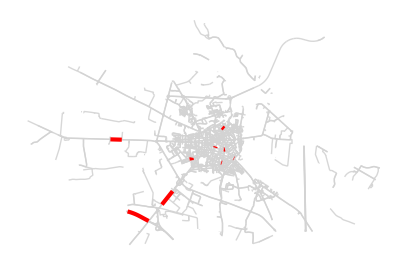

C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\1419956179.py:13: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  torino_high.plot(column='trend',color = 'r',legend=True,linewidth=3,ax=ax,alpha=1)


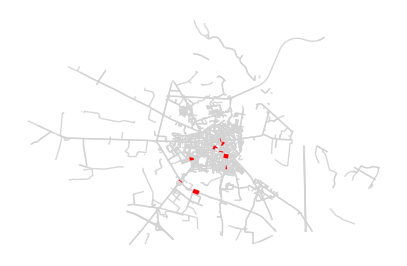

C:\Users\Asimina\AppData\Local\Temp\ipykernel_17168\1419956179.py:20: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  torino_high.plot(column='combined_score',color = 'r',legend=True,linewidth=3,ax=ax,alpha=1)


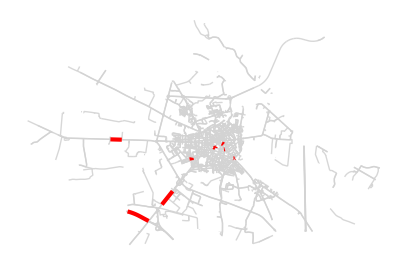

In [72]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots(figsize=(5, 5))
torino_sorted = torino.sort_values(by='static_risk_cluster', ascending=False)
torino_high = torino_sorted.head(10)
torino.plot(ax=ax, color='lightgrey', alpha=0.9, linewidth=1)
torino_high.plot(column='static_risk_cluster',color = 'r',legend=True,linewidth=3,ax=ax,alpha=1)
pyplt.axis('off')
pyplt.show()
fig, ax = pyplt.subplots(figsize=(5, 5))
torino_sorted = torino.sort_values(by='trend', ascending=False)
torino_high = torino_sorted.head(10)
torino.plot(ax=ax, color='lightgrey', alpha=0.9, linewidth=1)
torino_high.plot(column='trend',color = 'r',legend=True,linewidth=3,ax=ax,alpha=1)
pyplt.axis('off')
pyplt.show()
fig, ax = pyplt.subplots(figsize=(5, 5))
torino_sorted = torino.sort_values(by='combined_score', ascending=False)
torino_high = torino_sorted.head(10)
torino.plot(ax=ax, color='lightgrey', alpha=0.9, linewidth=1)
torino_high.plot(column='combined_score',color = 'r',legend=True,linewidth=3,ax=ax,alpha=1)
pyplt.axis('off')
pyplt.show()

Use Case 2: Risk of the 15 **municipalities** having the most road segments.

In [73]:
uidgroups['is_high_risk'] = uidgroups['risk_GMM'].apply(lambda x: 1 if x == 5 else 0)
uidgroups['is_high_trend'] = uidgroups['trend_GMM'].apply(lambda x: 1 if x == 9 else 0)
comgroups = uidgroups.groupby(['desc_comune'], as_index=False,sort=True).agg({'uid':'nunique','is_high_risk':'sum','is_high_trend':'sum','trend_scaled':'mean','static_risk_cluster_scaled':'mean','combined_score':'mean'})#'composite_risk':'mean','trend':'mean' #,'trend_GMM':'first','risk_GMM':'first','risk_GMM_6':'first','desc_comune':'first'})
comgroups['high_risk_percentage'] = 100*comgroups['is_high_risk'] / comgroups['uid']
comgroups['high_trend_percentage'] = 100*comgroups['is_high_trend'] / comgroups['uid']
comgroups = comgroups.rename(columns={
    'uid': 'nof_road_segments',
    'desc_comune': 'municipality',
    'trend_scaled': 'average_trend_scaled',
    'static_risk_cluster_scaled': 'average_static_risk_cluster_scaled',
    'combined_score': 'average_combined_score',
    'trend_scaled': 'average_trend_scaled',
    'is_high_risk': 'nof_high_risk_segments',
    'is_high_trend': 'nof_high_trend_segments',
})

# Apply formatting manually for printing
comgroups['high_risk_percentage'] = comgroups['high_risk_percentage'].map('{:.1f}'.format)
comgroups['high_trend_percentage'] = comgroups['high_trend_percentage'].map('{:.1f}'.format)
comgroups['average_static_risk_cluster_scaled'] = comgroups['average_static_risk_cluster_scaled'].map('{:.3f}'.format)
comgroups['average_combined_score'] = comgroups['average_combined_score'].map('{:.3f}'.format)
comgroups['average_trend_scaled'] = comgroups['average_trend_scaled'].map('{:.3f}'.format)

cols = ['municipality','nof_road_segments','nof_high_risk_segments','nof_high_trend_segments','high_risk_percentage','high_trend_percentage'] 
comgroups = comgroups[cols + [col for col in comgroups.columns if col not in cols]]

comgroups = comgroups.sort_values(by='nof_road_segments', ascending=False)
comgroups.to_csv('Municipality_Statistics.csv', index=True)
comgroups.head(n=15)

,municipality,nof_road_segments,nof_high_risk_segments,nof_high_trend_segments,high_risk_percentage,high_trend_percentage,average_trend_scaled,average_static_risk_cluster_scaled,average_combined_score
3443,TORINO,21334,169,203,0.8,1.0,0.357,0.182,0.269
111,ASTI,13218,2,7,0.0,0.1,0.358,0.021,0.189
3636,VERCELLI,5722,1,10,0.0,0.2,0.359,0.024,0.191
2348,NOVARA,4116,6,10,0.1,0.2,0.358,0.097,0.228
1357,CUNEO,3449,8,1,0.2,0.0,0.358,0.066,0.212
3467,TORTONA,3397,5,1,0.1,0.0,0.358,0.032,0.195
2177,MONDOVI',3065,0,1,0.0,0.0,0.358,0.019,0.188
1567,FOSSANO,3059,0,0,0.0,0.0,0.358,0.023,0.191
2167,MONCALIERI,3058,20,3,0.7,0.1,0.356,0.058,0.207
2892,RIVOLI,2843,18,17,0.6,0.6,0.359,0.063,0.211


Top 5 municipalisties having the highest average risk. 

In [74]:
sortedd = comgroups.sort_values(by='average_static_risk_cluster_scaled', ascending=False)
top_5 = sortedd['municipality'].head(5)
top_5_list = top_5.tolist()
print('Static Risk: ',top_5_list)
sortedd = comgroups.sort_values(by='average_trend_scaled', ascending=False)
top_5 = sortedd['municipality'].head(5)
top_5_list = top_5.tolist()
print('Dynamic Risk: ',top_5_list)
sortedd = comgroups.sort_values(by='average_combined_score', ascending=False)
top_5 = sortedd['municipality'].head(5)
top_5_list = top_5.tolist()
print('Combined Risk: ',top_5_list)

Static Risk:  ['Paruzzaro', 'PAGLIATE', 'Robilante', 'Borgo Ticino', 'NIVETTA']
Dynamic Risk:  ["Diano d'Alba", 'Paruzzaro', 'PALLANZA', 'Monastero di Vasco', "Borgo d'Ale"]
Combined Risk:  ['Paruzzaro', 'PAGLIATE', 'Borgo Ticino', 'Robilante', 'NIVETTA']


Use Case 3: Risk of the 10 **roads** comprising the most road segments.

In [75]:
cols_to_front = ['uid','trend','trend_GMM','risk_GMM','static_risk_cluster','trend_scaled','combined_score','static_risk_cluster_scaled']
uidgroups = uidgroups[cols_to_front + [c for c in uidgroups.columns if c not in cols_to_front]]
uidgroups.head(1)
road = uidgroups.dropna(subset=['fk_l2'])
roadgroup = uidgroups.dropna(subset=['group_strada'])
roadgroup['is_high_risk'] = roadgroup['risk_GMM'].apply(lambda x: 1 if x == 5 else 0)
roadgroup['is_high_trend'] = roadgroup['trend_GMM'].apply(lambda x: 1 if x == 9 else 0)
groupss = gpd.GeoDataFrame(roadgroup, geometry='u_geometria')

groups = groupss.groupby(['group_strada'], as_index=False,sort=True).agg({'uid':'nunique','is_high_risk':'sum','is_high_trend':'sum','trend_scaled':'mean','static_risk_cluster_scaled':'mean','combined_score':'mean'})
# groups['combined_score'] = 0.5*groups['static_risk_cluster_scaled'] + 0.5*groups['trend_scaled']
groups['high_risk_percentage'] = 100*groups['is_high_risk'] / groups['uid']
groups['high_trend_percentage'] = 100*groups['is_high_trend'] / groups['uid']
groups = groups.rename(columns={
    'uid': 'nof_road_segments',
    'group_strada': 'road_group',
    'trend_scaled': 'average_trend_scaled',
    'static_risk_cluster_scaled':'average_static_risk_cluster_scaled',
    'combined_score': 'average_combined_score',
    'is_high_risk': 'nof_high_risk_segments',
    'is_high_trend': 'nof_high_trend_segments',
})

groups['high_risk_percentage'] = groups['high_risk_percentage'].map('{:.1f}'.format)
groups['high_trend_percentage'] = groups['high_trend_percentage'].map('{:.1f}'.format)
groups['average_static_risk_cluster_scaled'] = groups['average_static_risk_cluster_scaled'].map('{:.3f}'.format)
groups['average_combined_score'] = groups['average_combined_score'].map('{:.3f}'.format)
groups['average_trend_scaled'] = groups['average_trend_scaled'].map('{:.3f}'.format)

cols = ['road_group','nof_road_segments','nof_high_risk_segments','nof_high_trend_segments','high_risk_percentage','high_trend_percentage'] 
groups = groups[cols + [col for col in groups.columns if col not in cols]]

groups = groups.sort_values(by='nof_road_segments', ascending=False)
groups.head(n=10)

C:\Users\Asimina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,road_group,nof_road_segments,nof_high_risk_segments,nof_high_trend_segments,high_risk_percentage,high_trend_percentage,average_trend_scaled,average_static_risk_cluster_scaled,average_combined_score
82557,fkl3_70652,886,0,0,0.0,0.0,0.358,0.039,0.199
81416,fkl3_50061,880,2,0,0.2,0.0,0.358,0.074,0.216
81669,fkl3_60050,796,1,2,0.1,0.3,0.359,0.036,0.197
81366,fkl3_50003,757,3,1,0.4,0.1,0.358,0.081,0.219
81411,fkl3_50054,751,3,1,0.4,0.1,0.358,0.052,0.205
81424,fkl3_50073,723,2,1,0.3,0.1,0.359,0.073,0.216
81421,fkl3_50069,695,1,0,0.1,0.0,0.358,0.094,0.226
64324,fkl2_52165,660,0,0,0.0,0.0,0.358,0.002,0.180
81410,fkl3_50053,657,2,1,0.3,0.2,0.357,0.099,0.228
81425,fkl3_50074,617,2,0,0.3,0.0,0.358,0.072,0.215


In [76]:
torino_sorted = groups.sort_values(by='nof_road_segments', ascending=False)
top_10_uids = torino_sorted.head(100)
roadgroup['groupstrada_in'] = roadgroup.group_strada.isin(top_10_uids.road_group).astype(int)
roadgroup['groupstrada_in'].unique()

C:\Users\Asimina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


array([0, 1])

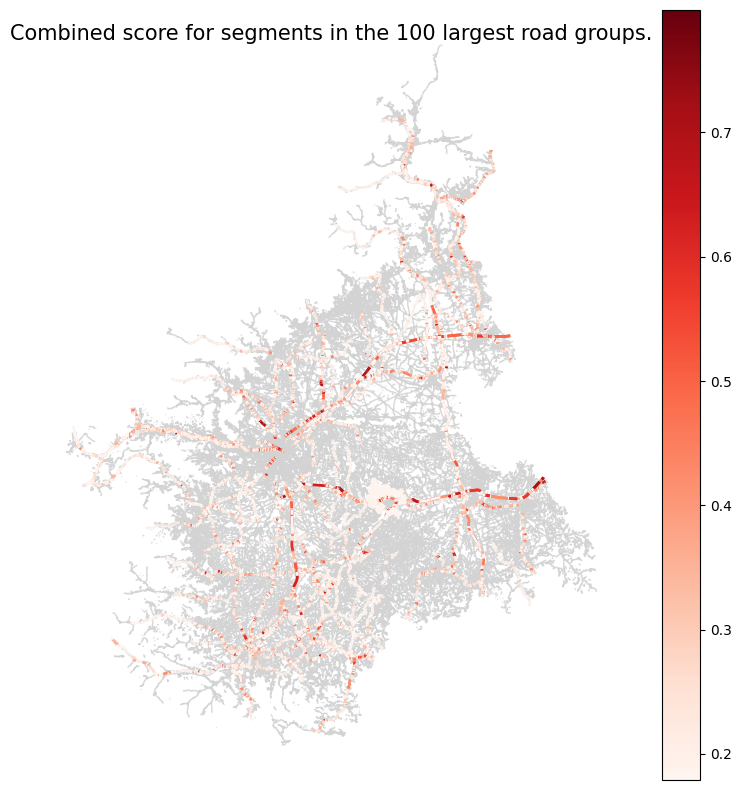

In [77]:
import matplotlib.pyplot as pyplt
fig, ax = pyplt.subplots(figsize=(10, 10))
torino_high = roadgroup[roadgroup['groupstrada_in'] == 1]

roadgroup.plot(ax=ax, color='lightgrey', alpha=0.9, linewidth=1)
torino_high.plot(column='combined_score',cmap='Reds',legend=True,linewidth=2,ax=ax,alpha=1)
pyplt.axis('off')
pyplt.title('Combined score for segments in the 100 largest road groups.', fontsize=15, y = 0.95)
pyplt.show()

POINTS

In [78]:
uidgroups2 = uidgroups.copy()

In [79]:
from shapely.geometry import Point
import geopandas as gpd
coords = [(45.0391321217653, 7.653491969403657), (45.036598863175726, 7.673491928837456)]

# Convert to Points (swap lat, lon → lon, lat) and assign IDs
data = [{'id': f'P{i+1}', 'geometry': Point(lon, lat)} for i, (lat, lon) in enumerate(coords)]
points_gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# 3. Reproject points to UTM to match
uidgroups2.set_crs(epsg=32632, inplace=True)
points_gdf = points_gdf.to_crs(uidgroups2.crs)
# 4. Now safe to buffer and join
uidgroups2['geometry_buffered'] = uidgroups2.geometry.buffer(50)
uidgroups_buffered = uidgroups2.set_geometry('geometry_buffered')
# 5. Spatial join
matches = gpd.sjoin(points_gdf, uidgroups_buffered, how='left', predicate='intersects')

matches = matches.merge(
    uidgroups2[['geometry_buffered']],  # what we want to bring back
    left_on='index_right', right_index=True,
    how='left'#,
    # suffixes=('', '_road')  # avoid geometry name conflict
)
# Compute distance from point (matches.geometry) to matched road (geometry_road)
matches['distance'] = matches.geometry.distance(matches['u_geometria'])
matches.sort_values(by=['id','distance'], ascending=[True,True])

,id,geometry,index_right,uid,trend,trend_GMM,risk_GMM,static_risk_cluster,trend_scaled,combined_score,static_risk_cluster_scaled,initial_risk_GMM,risk_GMM_0,risk_GMM_1,risk_GMM_2,risk_GMM_3,risk_GMM_4,risk_GMM_5,desc_comune,nr_incidenti,nr_incidenti_feriti,nr_incidenti_morti,nr_feriti,nr_morti,u_geometria,fk_l3,fk_l2,cod_comune,group_strada,flusso_medio_gior,accident_in_uuid,accidents_with_neighbours,accidents_inj_with_neighbours,accidents_d_with_neighbours,n_inj_with_neighbours_list,n_d_with_neighbours_list,is_high_risk,is_high_trend,geometry_buffered,distance
0,P1,POINT (393946.832 4988179.362),311295,093CB266-7D99-2909-E054-0003BA0F36E6,-1.1786,1.0000,4.0000,10.0000,0.2785,0.5559,0.8333,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,TORINO,14,14,0,23,0,"LINESTRING (393983.406 4988213.5, 393926.969 4...",0.0000,17936.0000,1272.0000,fkl2_17936,13606.0000,1,66.0000,66.0000,0.0000,111.0000,0.0000,0,0,"POLYGON ((393966.002 4988111.753, 393962.751 4...",7.2179
0,P1,POINT (393946.832 4988179.362),311306,093CB266-7DD0-2909-E054-0003BA0F36E6,-1.0000,1.0000,4.0000,10.0000,0.2905,0.5619,0.8333,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,TORINO,7,7,0,10,0,"LINESTRING (393967.563 4988220, 393928.906 498...",0.0000,17936.0000,1272.0000,fkl2_17936,3224.0000,1,40.0000,40.0000,0.0000,61.0000,0.0000,0,0,"POLYGON ((393967.355 4988141.536, 393964.037 4...",10.0372
0,P1,POINT (393946.832 4988179.362),311310,093CB266-7DE4-2909-E054-0003BA0F36E6,-1.0357,1.0000,4.0000,10.0000,0.2881,0.5607,0.8333,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,TORINO,5,5,0,9,0,"LINESTRING (393928.906 4988173.5, 393915.656 4...",0.0000,17936.0000,1272.0000,fkl2_17936,2935.0000,1,39.0000,39.0000,0.0000,65.0000,0.0000,0,0,"POLYGON ((393954.641 4988125.693, 393951.385 4...",18.8598
0,P1,POINT (393946.832 4988179.362),311318,093CB266-7E0C-2909-E054-0003BA0F36E6,-0.7500,2.0000,4.0000,10.0000,0.3074,0.5704,0.8333,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,TORINO,1,1,0,1,0,"LINESTRING (393928.906 4988173.5, 393923.219 4...",0.0000,17936.0000,1272.0000,fkl2_17936,156.0000,1,49.0000,49.0000,0.0000,77.0000,0.0000,0,0,"POLYGON ((393914.561 4988125.255, 393909.291 4...",18.8598
0,P1,POINT (393946.832 4988179.362),311302,093CB266-7DBC-2909-E054-0003BA0F36E6,-0.4643,3.0000,4.0000,10.0000,0.3267,0.5800,0.8333,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,TORINO,3,3,0,8,0,"LINESTRING (393992.219 4988199.5, 393940 49881...",0.0000,17936.0000,1272.0000,fkl2_17936,5891.0000,1,38.0000,38.0000,0.0000,66.0000,0.0000,0,0,"POLYGON ((393978.741 4988103.89, 393975.456 49...",22.4357
0,P1,POINT (393946.832 4988179.362),311316,093CB266-7E02-2909-E054-0003BA0F36E6,0.0000,0.0000,0.0000,0.0000,0.3581,0.1791,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,TORINO,0,0,0,0,0,"LINESTRING (393926.969 4988143, 393915.656 498...",0.0000,17936.0000,1272.0000,fkl2_17936,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,"POLYGON ((393876.766 4988125.574, 393873.873 4...",38.3032
0,P1,POINT (393946.832 4988179.362),311315,093CB266-7DFD-2909-E054-0003BA0F36E6,-1.2143,1.0000,4.0000,10.0000,0.2761,0.5547,0.8333,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,TORINO,2,2,0,6,0,"LINESTRING (393915.656 4988157, 393907.813 498...",0.0000,17936.0000,1272.0000,fkl2_17936,11186.0000,1,45.0000,45.0000,0.0000,71.0000,0.0000,0,0,"POLYGON ((393865.96 4988141.644, 393863.934 49...",38.3303
0,P1,POINT (393946.832 4988179.362),311305,093CB266-7DCB-2909-E054-0003BA0F36E6,-1.0714,1.0000,4.0000,10.0000,0.2857,0.5595,0.8333,3.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,TORINO,1,1,0,2,0,"LINESTRING (393915.656 4988157, 393897.938 498...",0.0000,17936.0000,1272.0000,fkl2_17936,2917.0000,1,45.0000,45.0000,0.0000,77.0000,0.0000,0,0,"POLYGON ((393936.153 4988103.757, 393932.809 4...",38.3662
0,P1,POINT (393946.832 4988179.362),346413,093CB269-3778-2909-E054-0003BA0F36E6,0.0000,0.0000,0.0000,0.0000,0.3581,0.1791,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,TORINO,0,0,0,0,0,"LINESTRING (393933.906 

In [80]:
matches_accidents = matches[matches['accident_in_uuid'] == 1]
p1 = matches_accidents[matches_accidents['id'] == 'P1'].sort_values(by='distance', ascending=True)
print(p1.shape)
p2 = matches_accidents[matches_accidents['id'] == 'P2'].sort_values(by='distance', ascending=True)
print(p2.shape)

(15, 40)
(7, 40)


In [81]:
cols = ['uid','distance','nr_incidenti', 'nr_incidenti_feriti','nr_incidenti_morti', 'nr_feriti', 'nr_morti',
         'accidents_with_neighbours','accidents_inj_with_neighbours','accidents_d_with_neighbours','n_inj_with_neighbours_list','n_d_with_neighbours_list',
         'risk_GMM','static_risk_cluster_scaled','trend','trend_scaled','combined_score'] 
p1 = p1[cols + [col for col in p1.columns if col not in cols]]
p1.head()
p1.to_csv('location_1.csv', index=False)

In [82]:
p2 = p2[cols + [col for col in p2.columns if col not in cols]]
p2.head()
p2.to_csv('location_2.csv', index=False)

In [83]:
from shapely.ops import unary_union

buffer_dist = 500  # in metres

# Buffer each point
point_buffers = points_gdf.copy()#test_point.copy()
point_buffers['geometry'] = point_buffers.geometry.buffer(buffer_dist)

# Combine into one shape
combined_buffer = unary_union(point_buffers.geometry)
nearby_roads = uidgroups2[uidgroups2.geometry.intersects(combined_buffer)]

# Add matched road geometry to matches
matches_with_geom = matches.merge(#test_match.merge(
    uidgroups2[['u_geometria']],  # the original roads
    left_on='index_right', right_index=True,
    how='left'
)



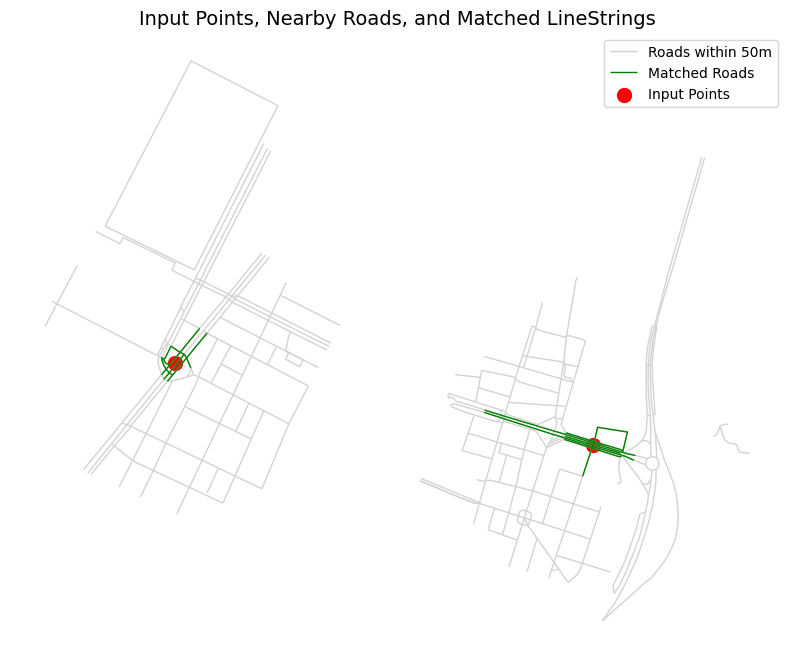

In [84]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# ⚫ Roads within 50m
nearby_roads.plot(ax=ax, color='lightgray', linewidth=1, label='Roads within 50m')

# 🟢 Matched road LineStrings
matches_with_geom.set_geometry('u_geometria_x').plot(ax=ax, color='green', linewidth=1, label='Matched Roads')

# 🔴 Input points
points_gdf.plot(ax=ax, color='red', markersize=100, label='Input Points')

# Optional: buffer area
# point_buffers.plot(ax=ax, color='blue', alpha=0.2, label='50m Buffer')

# Customise plot
ax.set_title("Input Points, Nearby Roads, and Matched LineStrings", fontsize=14)
ax.legend()
ax.axis('off')

plt.show()
